In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xscale

In [2]:
fname = '//home/z3526974/Work/data/Shelf_moorings/SYD140/IMOS_ANMN-NSW_TZ_20080625_SYD140_FV01_TEMP-aggregated-timeseries_END-20190501_C-20190819.nc'

nc = xr.open_dataset(fname)
nc

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 855, OBSERVATION: 17036420)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LONGITUDE                 (INSTRUMENT) float32 ...
    LATITUDE                  (INSTRUMENT) float32 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) int8 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int32 ...
    instrument_id             (INSTRUMENT) |S256 ...
    source_file               (INSTRUMENT) |S25

## Read in chosen variables to pandas dataframe

In [3]:
df = pd.DataFrame({'TIME': nc.TIME, 'TEMP': nc.TEMP, 'TEMPqc': nc.TEMP_quality_control, 'DEPTH' : nc.DEPTH}).set_index('TIME')
df.head(5)

,TEMP,TEMPqc,DEPTH
TIME,,,
2008-06-25 00:00:04.500005888,18.677299,1.0,31.097837
2008-06-25 00:05:04.499997952,18.726694,1.0,30.718990
2008-06-25 00:10:04.500000256,18.714445,1.0,30.674641
2008-06-25 00:15:04.500002304,18.483624,1.0,30.774830
2008-06-25 00:20:04.500004608,18.428225,1.0,30.720150


## Apply quality control flags

In [4]:
df.TEMPqc.value_counts()

1.0    16861769
3.0      172164
4.0        2485
2.0           2
Name: TEMPqc, dtype: int64

In [5]:
df_good = df[df.TEMPqc == 1]
df_good.TEMPqc.value_counts()

1.0    16861769
Name: TEMPqc, dtype: int64

## Now use groupby to get particular depths

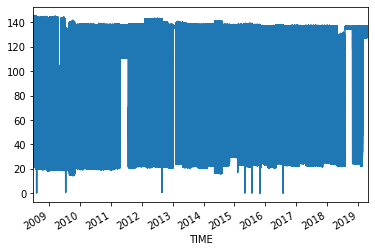

In [6]:
df_good.DEPTH.plot()

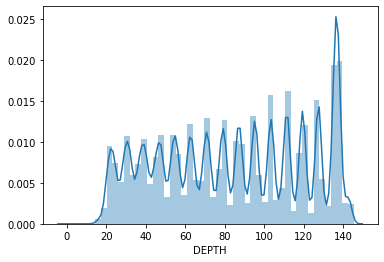

In [7]:
#get distribution of depths
sns.distplot(df_good['DEPTH'].dropna())

In [8]:
binned = pd.cut(x=df_good.DEPTH, bins=[-np.inf, 30, 60,80, np.inf], right=False, labels=['surface', '30-60', '60-80' , 'bottom'])
grouped = df_good.groupby(binned)
surface_temp_1D = grouped.get_group('surface').TEMP.resample('1D').mean()
bottom_temp_1D = grouped.get_group('bottom').TEMP.resample('1D').mean()
surface_temp_1M = surface_temp_1D.resample('1M')

In [12]:
# Compute the centered 7-day rolling mean
surface_temp_7D = surface_temp_1D.rolling(7, center=True,min_periods=1).mean()
bottom_temp_7D = bottom_temp_1D.rolling(7, center=True,min_periods=1).mean()

#Compute the centered 365-day rolling mean
# Compute the centered 7-day rolling mean
surface_temp_1Y = surface_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()
bottom_temp_1Y = bottom_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()
SYD140_surface_raw = surface_temp_1Y
%store SYD140_surface_raw
SYD140_surface_raw

Stored 'SYD140_surface_raw' (Series)


TIME
2008-06-25    18.705777
2008-06-26    18.711314
2008-06-27    18.717057
2008-06-28    18.722761
2008-06-29    18.728488
                ...    
2019-02-20    19.843686
2019-02-21    19.842840
2019-02-22    19.841626
2019-02-23    19.839679
2019-02-24    19.838097
Freq: D, Name: TEMP, Length: 3897, dtype: float64

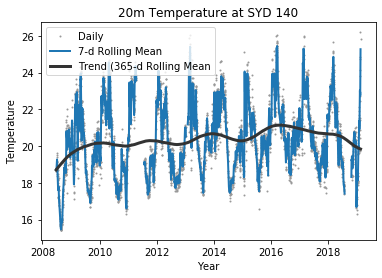

In [10]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(surface_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(surface_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('20m Temperature at SYD 140');
plt.savefig('SYD140_20m_temperature_tseries.png', dpi=300,bbox_inches='tight')

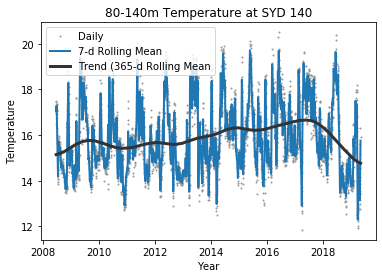

In [11]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(bottom_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(bottom_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(bottom_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-140m Temperature at SYD 140');
plt.savefig('SYD140_80-140m_temperature_tseries.png', dpi=300,bbox_inches='tight')

## OK, so this is cute, but to keep things consistent with the SST analysis, and for gapfilling lets rather convert to an Xarray dataset and proceed from there.

In [12]:
DA_surfacetemp = surface_temp_1D.to_xarray()
ds = DA_surfacetemp.to_dataset()
ds = ds.rename({'TIME': 'time'})
ds

<xarray.Dataset>
Dimensions:  (time: 3897)
Coordinates:
  * time     (time) datetime64[ns] 2008-06-25 2008-06-26 ... 2019-02-24
Data variables:
    TEMP     (time) float32 18.704622 18.809576 18.640331 ... nan 25.828089

## Remove seasonal cycle


In [13]:
def xarray_trend(xarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value
    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr.to_dataset(name=xarr.name)
    # first create variable for slope and adjust meta
    out['slope'] = xarr[:2].mean('time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xarr[:2].mean('time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")

    return out

<xarray.Dataset>
Dimensions:  (time: 3897)
Coordinates:
  * time     (time) datetime64[ns] 2008-06-25 2008-06-26 ... 2019-02-24
Data variables:
    TEMP     (time) float32 18.704622 18.809576 18.640331 ... nan 25.828089
    slope    float64 0.0002948
    pval     float64 2.161e-29

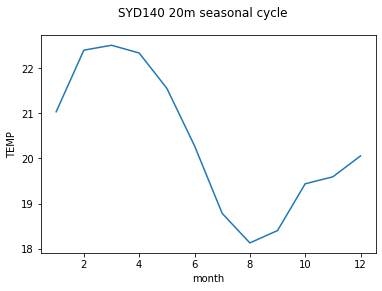

In [14]:
climatology = ds.TEMP.groupby('time.month').mean('time')
anomalies = ds.TEMP.groupby('time.month') - climatology
climatology.plot()
plt.suptitle("SYD140 20m seasonal cycle")
plt.savefig('SYD140_20m_seasonal_cycle.png', dpi=300,bbox_inches='tight')
#get linear trend
trend = xarray_trend(ds.TEMP)
trend

In [15]:
decade_trend = trend.slope*3650
decade_trend

<xarray.DataArray 'slope' ()>
array(1.076144)

In [23]:
SYD_140_anomalies = anomalies
#SYD_140_anomalies.plot()
SYD_140_anomalies.to_netcdf

<bound method DataArray.to_netcdf of <xarray.DataArray 'TEMP' (time: 3897)>
array([-1.576603, -1.471649, -1.640894, ...,  3.79459 ,       nan,  3.431568],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2008-06-25 2008-06-26 ... 2019-02-24
    month    (time) int64 6 6 6 6 6 6 7 7 7 7 7 7 7 ... 2 2 2 2 2 2 2 2 2 2 2 2>

In [24]:
y = surface_temp_1D.fillna(surface_temp_1D.ffill())

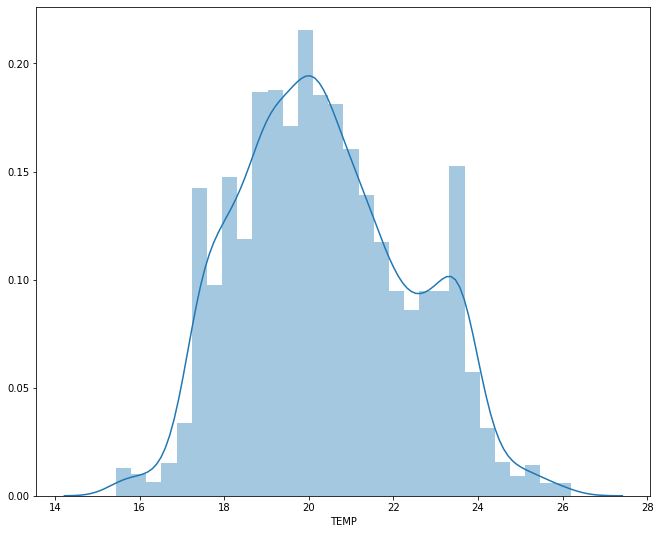

In [25]:
sns.distplot(y)